# BERT classification

# Table of Contents
## [Notebook Introduction](#intro)
## [Data Preprocessing](#preprocessing)
## [Modeling](#bert)
## [Next Steps](#next)

<a id=Intro></a>
## Notebook Introduction
The purpose of this notebook is to explore and experiment with neural networks, and finetuning of a pre-trained model, BERT to classify reviews. There is a restriction to this type of modeling for this dataset and that is it could only evaluate based on one column which will be `review_body` in this case and not `review_headline` or any other features.

<a id="data"></a>
## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import scipy.sparse as sp
import shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # To get rid of error messages
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Limit GPU memory to avoid memory issue
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
# check if GPU is being used
len(tf.config.list_physical_devices('GPU'))>0

True

In [4]:
# Load the dataframes
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,1,,do not buy really didn t start to wear them u...,2015,8
1,Teva Men's Pajaro Flip-Flop,5,0,0,1,super flip flop,provides great cushion as well as archsupport,2015,8
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,1,badass,getting what u see,2015,8
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,1,three stars,small,2015,8
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,1,five stars,my 13 year old son loved these shoes excellent...,2015,8
...,...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,0,what a waste,i purchased this shoe because it looked good ...,2002,10
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,0,you want it you need it,this little shoe boot is so great if you re th...,2002,10
4358812,Women's CanvasMule Shoes,5,0,0,0,cute,the backless mule is very comfortable cute ...,2002,9
4358813,Birki's Super Birki Unisex Clog,5,10,11,0,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002,3


In [5]:
with open('2ClassDf.pkl', 'rb') as f:
    df2 = pickle.load(f)
df2

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
0,Minnetonka Men's Double Deerskin Softsole Mocc...,0,0,0,1,,do not buy really didn t start to wear them u...,2015,8
1,Teva Men's Pajaro Flip-Flop,1,0,0,1,super flip flop,provides great cushion as well as archsupport,2015,8
3,adidas Men's 10K Lifestyle Runner Sneaker,1,0,6,1,badass,getting what u see,2015,8
4,OverBling Sneakers for Men Casual Men Shoes Ge...,0,0,0,1,three stars,small,2015,8
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),1,1,1,1,five stars,my 13 year old son loved these shoes excellent...,2015,8
...,...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,0,0,0,0,what a waste,i purchased this shoe because it looked good ...,2002,10
4358811,Women's Bree Suede Moc Snow Joggers,1,1,1,0,you want it you need it,this little shoe boot is so great if you re th...,2002,10
4358812,Women's CanvasMule Shoes,1,0,0,0,cute,the backless mule is very comfortable cute ...,2002,9
4358813,Birki's Super Birki Unisex Clog,1,10,11,0,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002,3


In [318]:
# Dropping all columns except review_body
reviews_df = df2.drop(columns=['product_title', 'helpful_votes', 'total_votes', 'review_headline', 'verified_purchase', 'year', 'month'])

In [319]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(5000, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(5000, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [8]:
# # THIS IS FULL DATASET WHICH TAKES TOO LONG TO RUN SO WILL SKIP
# # Grabbing the size of 0 class to downsample class 1 to
# size = reviews_df[reviews_df['star_rating']==0].shape[0]
# size

# bad_rating = reviews_df[reviews_df['star_rating']==0]
# good_rating = reviews_df[reviews_df['star_rating']==1].sample(size, random_state=1)

# reviews_df = pd.concat([bad_rating, good_rating])

# # sanity check
# reviews_df

In [320]:
# assigning Reviewer_Score as target variable and everything else as X
X = reviews_df.drop(columns=['star_rating'])
y = reviews_df['star_rating']

In [321]:
# splitting the data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1, stratify=y_remainder)

<a id="bert"></a>
## Modeling

The code below is based on https://www.tensorflow.org/text/tutorials/classify_text_with_bert. It was of course modified to better suit this dataset as the architecture of the neural networks needed to be changed.

In [11]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
text_test = [reviews_df['review_body'].iloc[0]]
text_test

['fit as expected  they are high so you must know how to walk in heels ']

In [14]:
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4906 2004 3517 2027 2024 2152 2061 2017 2442 2113 2129]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
bert_results = bert_model(text_preprocessed)

In [17]:
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.7607368  -0.347117   -0.6029164   0.71696216  0.56025594 -0.04808362
  0.7076053   0.09796591 -0.26152787 -0.9999138  -0.29918137  0.80424714]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.0386393   0.04898733 -0.16313925 ... -0.28427884  0.08842307
   0.10473943]
 [ 0.85284096  0.04709627 -0.11416216 ... -0.4630256  -0.22701892
  -0.07458105]
 [ 0.9087467   0.06219945  0.43695045 ... -0.6395393   0.21653663
  -0.19696523]
 ...
 [ 0.32839     0.4996019  -0.11872302 ...  0.05329175  0.01395773
   0.20808186]
 [ 0.4815084   0.5257025   0.14983064 ... -0.80700505 -0.2427601
  -0.5762307 ]
 [ 0.10867378  0.7266112   0.4677907  ... -0.910317   -0.06867442
  -0.37919912]]


In [29]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [30]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.3993626]], shape=(1, 1), dtype=float32)


In [31]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [32]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [33]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(32)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [35]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [36]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [37]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
200/200 [==============================] - 205s 947ms/step - loss: 0.5737 - binary_accuracy: 0.6592 - val_loss: 0.4423 - val_binary_accuracy: 0.8100
Epoch 2/10
200/200 [==============================] - 190s 949ms/step - loss: 0.4039 - binary_accuracy: 0.8245 - val_loss: 0.4408 - val_binary_accuracy: 0.7950
Epoch 3/10
200/200 [==============================] - 190s 949ms/step - loss: 0.2955 - binary_accuracy: 0.8814 - val_loss: 0.4602 - val_binary_accuracy: 0.8025
Epoch 4/10
200/200 [==============================] - 190s 948ms/step - loss: 0.2211 - binary_accuracy: 0.9244 - val_loss: 0.6252 - val_binary_accuracy: 0.8062
Epoch 5/10
200/200 [==============================] - 190s 949ms/step - loss: 0.1642 - binary_accuracy: 0.9481 - val_loss: 0.7293 - val_binary_accuracy: 0.8019
Epoch 6/10
200/200 [==============================] - 190s 948ms/step - loss: 0.1425 - binary_accuracy: 0.9552 - val_

KeyboardInterrupt: 

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

In [ ]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [ ]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [63]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [103]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.59048235]], shape=(1, 1), dtype=float32)


In [104]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [105]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [67]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [68]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [69]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
64/64 [==============================] - 1489s 23s/step - loss: 0.5983 - binary_accuracy: 0.6734 - val_loss: 0.4556 - val_binary_accuracy: 0.8062
Epoch 2/10
64/64 [==============================] - 1488s 23s/step - loss: 0.4309 - binary_accuracy: 0.8191 - val_loss: 0.4361 - val_binary_accuracy: 0.8156
Epoch 3/10
64/64 [==============================] - 1508s 24s/step - loss: 0.3487 - binary_accuracy: 0.8628 - val_loss: 0.4610 - val_binary_accuracy: 0.8163
Epoch 4/10
64/64 [==============================] - 1512s 24s/step - loss: 0.2929 - binary_accuracy: 0.8894 - val_loss: 0.4892 - val_binary_accuracy: 0.8169
Epoch 5/10
64/64 [==============================] - 1523s 24s/step - loss: 0.2473 - binary_accuracy: 0.9091 - val_loss: 0.5980 - val_binary_accuracy: 0.8006
Epoch 6/10
64/64 [==============================] - 1522s 24s/step - loss: 0.1718 - binary_accuracy: 0.9445 - val_loss: 0.6395 - val

In [70]:
loss, accuracy = classifier_model.evaluate(test_ds)

20/20 [==============================] - 153s 8s/step - loss: 0.8467 - binary_accuracy: 0.7825


In [71]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.8467469215393066
Accuracy: 0.7825000286102295


In [72]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [73]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

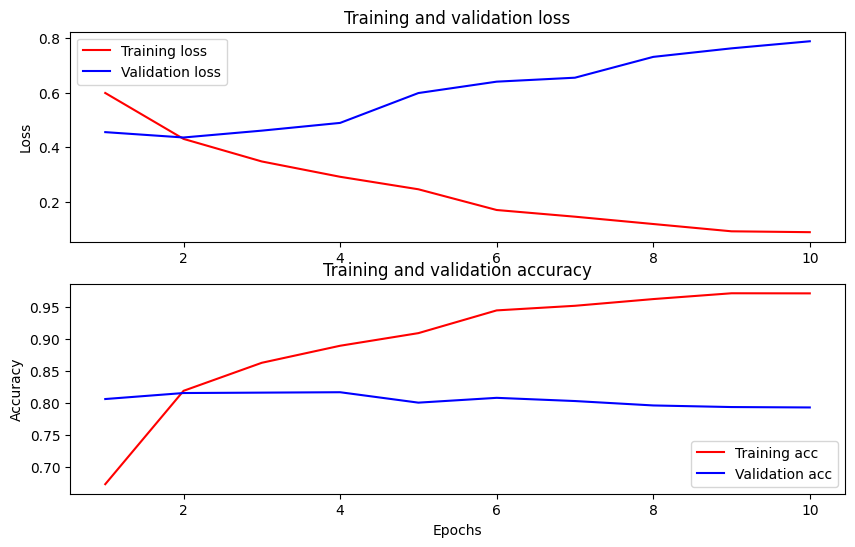

In [74]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [82]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(500, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(500, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [83]:
# assigning Reviewer_Score as target variable and everything else as X
X = reviews_df.drop(columns=['star_rating'])
y = reviews_df['star_rating']

In [84]:
# splitting the data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1, stratify=y_remainder)

In [85]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(100)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(100)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(100)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [106]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [107]:
classifier_model3 = build_classifier_model()
bert_raw_result = classifier_model3(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.600077]], shape=(1, 1), dtype=float32)


In [108]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [114]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [115]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [116]:
classifier_model3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [117]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model3.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
7/7 [==============================] - 167s 22s/step - loss: 0.6307 - binary_accuracy: 0.6587 - val_loss: 0.6053 - val_binary_accuracy: 0.7312
Epoch 2/10
7/7 [==============================] - 155s 22s/step - loss: 0.5463 - binary_accuracy: 0.7469 - val_loss: 0.5156 - val_binary_accuracy: 0.7188
Epoch 3/10
7/7 [==============================] - 153s 22s/step - loss: 0.4337 - binary_accuracy: 0.8047 - val_loss: 0.5738 - val_binary_accuracy: 0.7375
Epoch 4/10
7/7 [==============================] - 165s 24s/step - loss: 0.4068 - binary_accuracy: 0.8422 - val_loss: 0.5410 - val_binary_accuracy: 0.7375
Epoch 5/10
7/7 [==============================] - 154s 22s/step - loss: 0.3490 - binary_accuracy: 0.8625 - val_loss: 0.5421 - val_binary_accuracy: 0.7563
Epoch 6/10
7/7 [==============================] - 154s 22s/step - loss: 0.3047 - binary_accuracy: 0.8828 - val_loss: 0.6018 - val_binary_accuracy: 

In [118]:
loss, accuracy = classifier_model3.evaluate(test_ds)

2/2 [==============================] - 16s 8s/step - loss: 0.5686 - binary_accuracy: 0.7800


In [119]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.5685729384422302
Accuracy: 0.7799999713897705


In [100]:
classifier_model

In [95]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [96]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

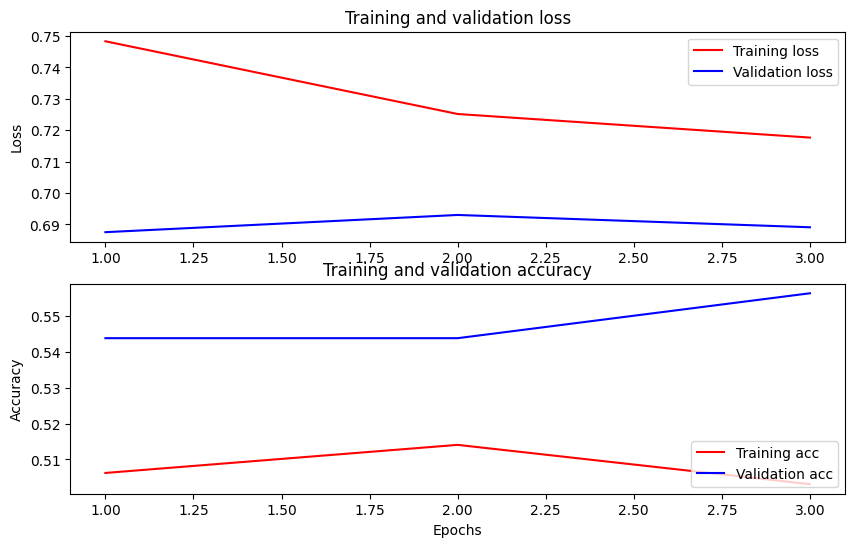

In [97]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

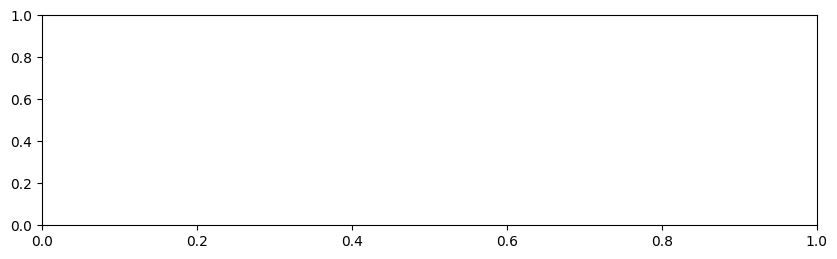

In [120]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(500, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(500, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [ ]:
# assigning Reviewer_Score as target variable and everything else as X
X = reviews_df.drop(columns=['star_rating'])
y = reviews_df['star_rating']

In [122]:
# splitting the data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1, stratify=y_remainder)

In [123]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(30)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(30)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(30)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [124]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [125]:
classifier_model3 = build_classifier_model()
bert_raw_result = classifier_model3(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6179557]], shape=(1, 1), dtype=float32)


In [126]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [127]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [128]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [129]:
classifier_model3.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [130]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model3.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
22/22 [==============================] - 192s 8s/step - loss: 0.7273 - binary_accuracy: 0.5063 - val_loss: 0.6522 - val_binary_accuracy: 0.6438
Epoch 2/10
22/22 [==============================] - 165s 8s/step - loss: 0.6219 - binary_accuracy: 0.6234 - val_loss: 0.5976 - val_binary_accuracy: 0.7312
Epoch 3/10
22/22 [==============================] - 167s 8s/step - loss: 0.4617 - binary_accuracy: 0.8031 - val_loss: 0.5227 - val_binary_accuracy: 0.7500
Epoch 4/10
22/22 [==============================] - 170s 8s/step - loss: 0.3164 - binary_accuracy: 0.8781 - val_loss: 0.6769 - val_binary_accuracy: 0.7563
Epoch 5/10
22/22 [==============================] - 167s 8s/step - loss: 0.1929 - binary_accuracy: 0.9453 - val_loss: 0.8264 - val_binary_accuracy: 0.7563
Epoch 6/10
22/22 [==============================] - 168s 8s/step - loss: 0.1658 - binary_accuracy: 0.9516 - val_loss: 0.8249 - val_binary_accu

In [131]:
loss, accuracy = classifier_model3.evaluate(test_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.9479 - binary_accuracy: 0.7500


In [132]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.9478791952133179
Accuracy: 0.75


In [133]:
classifier_model3

In [134]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [135]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

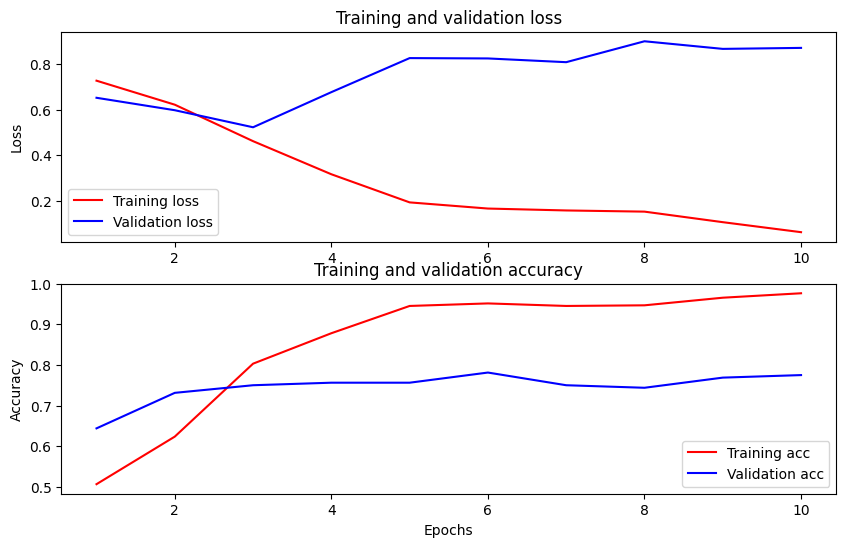

In [136]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [85]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(10)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(10)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(10)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [138]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [139]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.64421487]], shape=(1, 1), dtype=float32)


In [140]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [141]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [142]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [143]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [144]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
22/22 [==============================] - 187s 8s/step - loss: 0.8329 - binary_accuracy: 0.5047 - val_loss: 0.6654 - val_binary_accuracy: 0.6500
Epoch 2/10
22/22 [==============================] - 167s 8s/step - loss: 0.7575 - binary_accuracy: 0.5359 - val_loss: 0.6394 - val_binary_accuracy: 0.6625
Epoch 3/10
22/22 [==============================] - 168s 8s/step - loss: 0.6674 - binary_accuracy: 0.6031 - val_loss: 0.5807 - val_binary_accuracy: 0.7188
Epoch 4/10
22/22 [==============================] - 168s 8s/step - loss: 0.5882 - binary_accuracy: 0.6797 - val_loss: 0.5263 - val_binary_accuracy: 0.7437
Epoch 5/10
22/22 [==============================] - 168s 8s/step - loss: 0.4592 - binary_accuracy: 0.7984 - val_loss: 0.5426 - val_binary_accuracy: 0.7500
Epoch 6/10
22/22 [==============================] - 167s 8s/step - loss: 0.3908 - binary_accuracy: 0.8500 - val_loss: 0.5857 - val_binary_accu

In [147]:
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Epoch 1/10
22/22 [==============================] - 169s 8s/step - loss: 0.2102 - binary_accuracy: 0.9391 - val_loss: 0.6464 - val_binary_accuracy: 0.7563
Epoch 2/10
22/22 [==============================] - 166s 8s/step - loss: 0.2065 - binary_accuracy: 0.9312 - val_loss: 0.6464 - val_binary_accuracy: 0.7563
Epoch 3/10
22/22 [==============================] - 166s 8s/step - loss: 0.1953 - binary_accuracy: 0.9312 - val_loss: 0.6464 - val_binary_accuracy: 0.7563
Epoch 4/10
22/22 [==============================] - 163s 7s/step - loss: 0.2229 - binary_accuracy: 0.9359 - val_loss: 0.6464 - val_binary_accuracy: 0.7563
Epoch 5/10
22/22 [==============================] - 163s 7s/step - loss: 0.1947 - binary_accuracy: 0.9344 - val_loss: 0.6464 - val_binary_accuracy: 0.7563
Epoch 6/10
 6/22 [=======>......................] - ETA: 1:51 - loss: 0.2394 - binary_accuracy: 0.9167

KeyboardInterrupt: 

In [145]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.6155 - binary_accuracy: 0.7850


In [146]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.6155173778533936
Accuracy: 0.7850000262260437


In [100]:
classifier_model

In [95]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [96]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

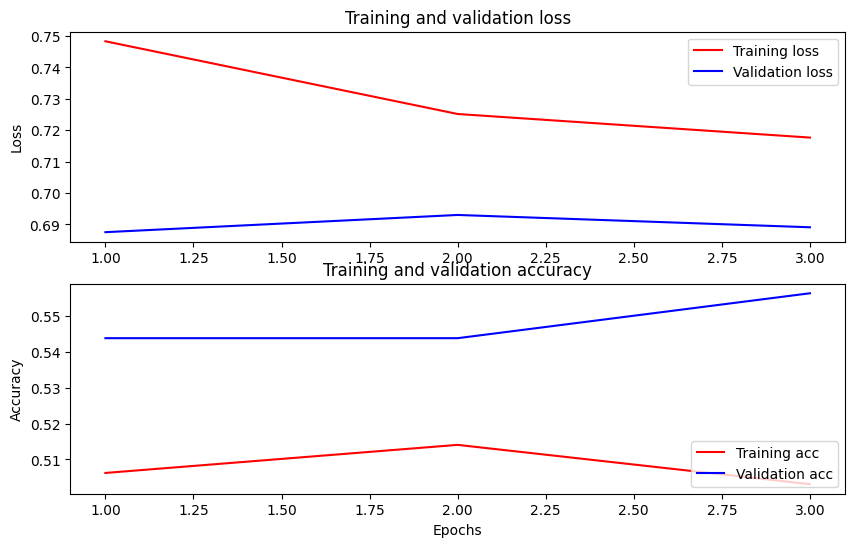

In [97]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [148]:
reviews_df = df2.drop(columns=['product_title', 'helpful_votes', 'total_votes', 'review_headline', 'verified_purchase', 'year', 'month'])

In [149]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(5000, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(5000, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [150]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(32)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [151]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [165]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.60713065]], shape=(1, 1), dtype=float32)


In [166]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [167]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [168]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [169]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [170]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 181s 8s/step - loss: 0.8256 - binary_accuracy: 0.4859 - val_loss: 0.7018 - val_binary_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 161s 8s/step - loss: 0.7693 - binary_accuracy: 0.4578 - val_loss: 0.6904 - val_binary_accuracy: 0.4938
Epoch 3/10
20/20 [==============================] - 160s 8s/step - loss: 0.7230 - binary_accuracy: 0.5063 - val_loss: 0.6767 - val_binary_accuracy: 0.6313
Epoch 4/10
20/20 [==============================] - 159s 8s/step - loss: 0.7052 - binary_accuracy: 0.5391 - val_loss: 0.6575 - val_binary_accuracy: 0.6187
Epoch 5/10
20/20 [==============================] - 161s 8s/step - loss: 0.6486 - binary_accuracy: 0.6109 - val_loss: 0.6217 - val_binary_accuracy: 0.7000
Epoch 6/10
20/20 [==============================] - 160s 8s/step - loss: 0.5839 - binary_accuracy: 0.6969 - val_loss: 0.5736 - val_binary_accu

In [172]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.4934 - binary_accuracy: 0.7950


In [173]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.49336913228034973
Accuracy: 0.7950000166893005


In [174]:
classifier_model

In [175]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [176]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

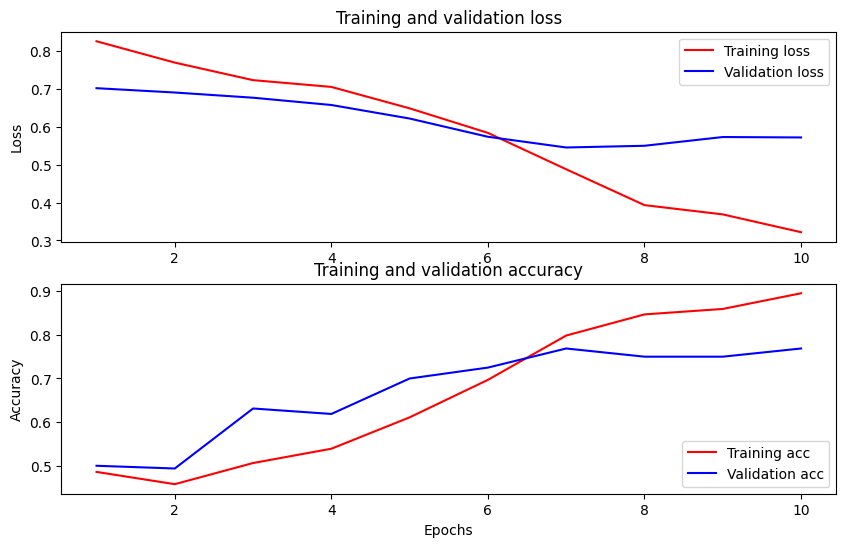

In [177]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [305]:
reviews_df = df2.drop(columns=['product_title', 'helpful_votes', 'total_votes', 'review_headline', 'verified_purchase', 'year', 'month'])

In [306]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(5000, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(5000, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [307]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(32)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [186]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [187]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6093239]], shape=(1, 1), dtype=float32)


In [188]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [189]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [190]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [191]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [192]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 179s 8s/step - loss: 0.8348 - binary_accuracy: 0.5078 - val_loss: 0.6838 - val_binary_accuracy: 0.5500
Epoch 2/10
20/20 [==============================] - 160s 8s/step - loss: 0.7425 - binary_accuracy: 0.5453 - val_loss: 0.6212 - val_binary_accuracy: 0.6438
Epoch 3/10
20/20 [==============================] - 161s 8s/step - loss: 0.6153 - binary_accuracy: 0.6641 - val_loss: 0.5615 - val_binary_accuracy: 0.7250
Epoch 4/10
20/20 [==============================] - 162s 8s/step - loss: 0.4834 - binary_accuracy: 0.7734 - val_loss: 0.6164 - val_binary_accuracy: 0.7375
Epoch 5/10
20/20 [==============================] - 159s 8s/step - loss: 0.4171 - binary_accuracy: 0.8328 - val_loss: 0.6232 - val_binary_accuracy: 0.7188
Epoch 6/10
20/20 [==============================] - 162s 8s/step - loss: 0.3306 - binary_accuracy: 0.8844 - val_loss: 0.6527 - val_binary_accu

In [193]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.7893 - binary_accuracy: 0.7700


In [194]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.7892940640449524
Accuracy: 0.7699999809265137


In [195]:
classifier_model

In [196]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [197]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

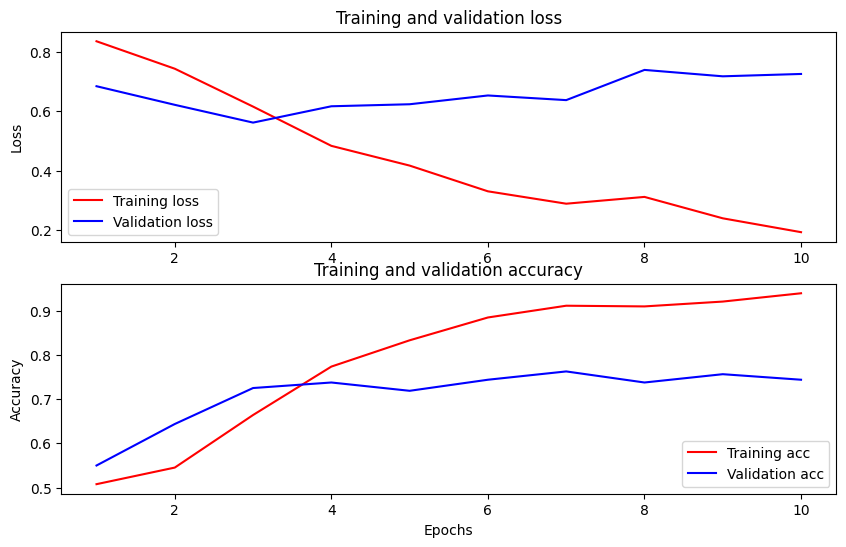

In [198]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [199]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [200]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6446214]], shape=(1, 1), dtype=float32)


In [201]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [202]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [203]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [204]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [205]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 176s 8s/step - loss: 0.8525 - binary_accuracy: 0.5078 - val_loss: 0.6581 - val_binary_accuracy: 0.6062
Epoch 2/10
20/20 [==============================] - 158s 8s/step - loss: 0.7190 - binary_accuracy: 0.5547 - val_loss: 0.6078 - val_binary_accuracy: 0.6625
Epoch 3/10
20/20 [==============================] - 161s 8s/step - loss: 0.6453 - binary_accuracy: 0.6516 - val_loss: 0.5686 - val_binary_accuracy: 0.7188
Epoch 4/10
20/20 [==============================] - 158s 8s/step - loss: 0.5537 - binary_accuracy: 0.7422 - val_loss: 0.5410 - val_binary_accuracy: 0.7750
Epoch 5/10
20/20 [==============================] - 157s 8s/step - loss: 0.5482 - binary_accuracy: 0.7656 - val_loss: 0.5249 - val_binary_accuracy: 0.7625
Epoch 6/10
20/20 [==============================] - 158s 8s/step - loss: 0.4012 - binary_accuracy: 0.8438 - val_loss: 0.6110 - val_binary_accu

In [206]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.6531 - binary_accuracy: 0.7800


In [207]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.6531224250793457
Accuracy: 0.7799999713897705


In [208]:
classifier_model

In [209]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [210]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

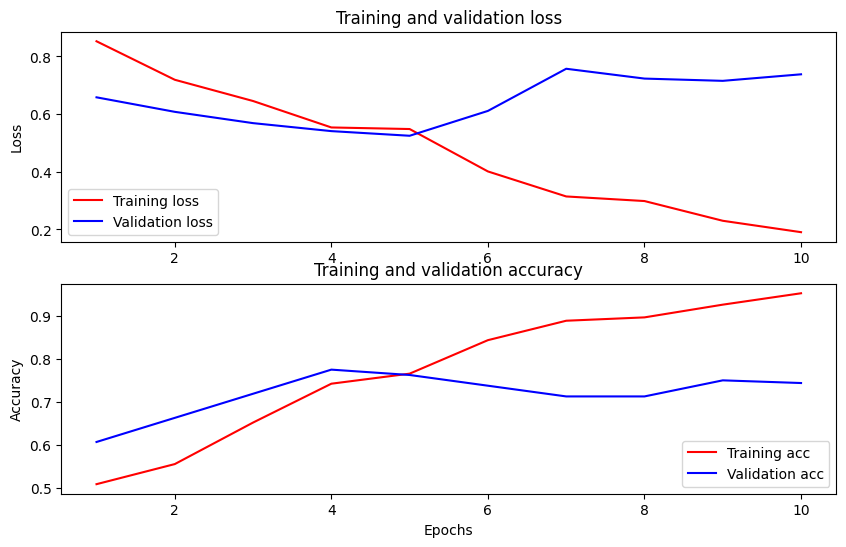

In [211]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [212]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    
    # Modify the architecture
    # net = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(net)
    net = tf.keras.layers.Conv1D(128, 5, activation='relu')(net)
    net = tf.keras.layers.GlobalMaxPooling1D()(net)
    net = tf.keras.layers.LSTM(64)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax')(net)
    
    return tf.keras.Model(text_input, net)

In [213]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5942572]], shape=(1, 1), dtype=float32)


In [214]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [215]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [216]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [217]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [225]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3


TypeError: unsupported operand type(s) for -: 'range' and 'int'

In [219]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.8214 - binary_accuracy: 0.7350


In [220]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.8213722705841064
Accuracy: 0.7350000143051147


In [221]:
classifier_model

In [222]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [223]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

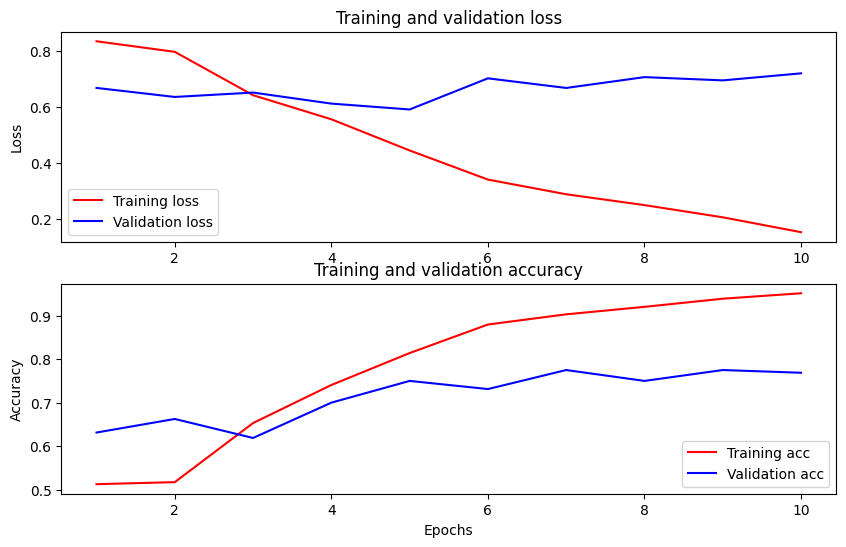

In [224]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [227]:
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
20/20 [==============================] - 157s 8s/step - loss: 0.1637 - binary_accuracy: 0.9578 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 2/10
20/20 [==============================] - 157s 8s/step - loss: 0.1745 - binary_accuracy: 0.9500 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 3/10
20/20 [==============================] - 157s 8s/step - loss: 0.1658 - binary_accuracy: 0.9578 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 4/10
20/20 [==============================] - 156s 8s/step - loss: 0.1565 - binary_accuracy: 0.9594 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 5/10
20/20 [==============================] - 157s 8s/step - loss: 0.1776 - binary_accuracy: 0.9563 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 6/10
20/20 [==============================] - 158s 8s/step - loss: 0.1498 - binary_accuracy: 0.9609 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 7/10
17/20 [========================>.....] - ETA: 21s - loss: 0

KeyboardInterrupt: 

In [212]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    
    # Modify the architecture
    net = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(net)
    net = tf.keras.layers.Conv1D(128, 5, activation='relu')(net)
    net = tf.keras.layers.GlobalMaxPooling1D()(net)
    net = tf.keras.layers.LSTM(64)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax')(net)
    
    return tf.keras.Model(text_input, net)

In [213]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5942572]], shape=(1, 1), dtype=float32)


In [214]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [215]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [216]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [217]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [225]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3


TypeError: unsupported operand type(s) for -: 'range' and 'int'

In [219]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.8214 - binary_accuracy: 0.7350


In [220]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.8213722705841064
Accuracy: 0.7350000143051147


In [221]:
classifier_model

In [222]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [223]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

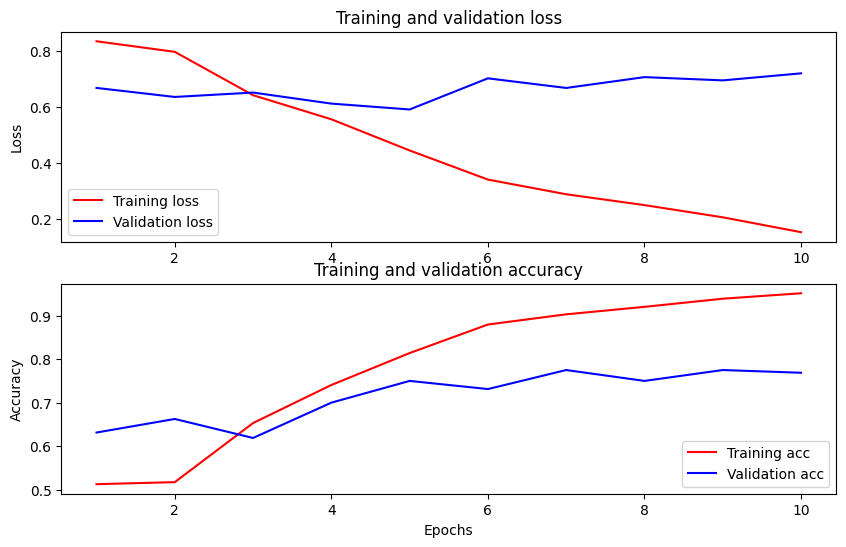

In [224]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [227]:
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=10)

Epoch 1/10
20/20 [==============================] - 157s 8s/step - loss: 0.1637 - binary_accuracy: 0.9578 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 2/10
20/20 [==============================] - 157s 8s/step - loss: 0.1745 - binary_accuracy: 0.9500 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 3/10
20/20 [==============================] - 157s 8s/step - loss: 0.1658 - binary_accuracy: 0.9578 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 4/10
20/20 [==============================] - 156s 8s/step - loss: 0.1565 - binary_accuracy: 0.9594 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 5/10
20/20 [==============================] - 157s 8s/step - loss: 0.1776 - binary_accuracy: 0.9563 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 6/10
20/20 [==============================] - 158s 8s/step - loss: 0.1498 - binary_accuracy: 0.9609 - val_loss: 0.7202 - val_binary_accuracy: 0.7688
Epoch 7/10
17/20 [========================>.....] - ETA: 21s - loss: 0

KeyboardInterrupt: 

In [243]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [244]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5816541]], shape=(1, 1), dtype=float32)


In [245]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [246]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [247]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [248]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [249]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 177s 8s/step - loss: 0.8552 - binary_accuracy: 0.5234 - val_loss: 0.6918 - val_binary_accuracy: 0.5125
Epoch 2/10
20/20 [==============================] - 155s 8s/step - loss: 0.7278 - binary_accuracy: 0.5500 - val_loss: 0.6524 - val_binary_accuracy: 0.6250
Epoch 3/10
20/20 [==============================] - 156s 8s/step - loss: 0.6664 - binary_accuracy: 0.6062 - val_loss: 0.6161 - val_binary_accuracy: 0.6687
Epoch 4/10
20/20 [==============================] - 161s 8s/step - loss: 0.6041 - binary_accuracy: 0.6781 - val_loss: 0.5636 - val_binary_accuracy: 0.7437
Epoch 5/10
20/20 [==============================] - 156s 8s/step - loss: 0.5171 - binary_accuracy: 0.7563 - val_loss: 0.5582 - val_binary_accuracy: 0.7500
Epoch 6/10
20/20 [==============================] - 157s 8s/step - loss: 0.3909 - binary_accuracy: 0.8484 - val_loss: 0.5867 - val_binary_accu

In [250]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.6071 - binary_accuracy: 0.7700


In [251]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.607056736946106
Accuracy: 0.7699999809265137


In [252]:
classifier_model

In [253]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [254]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

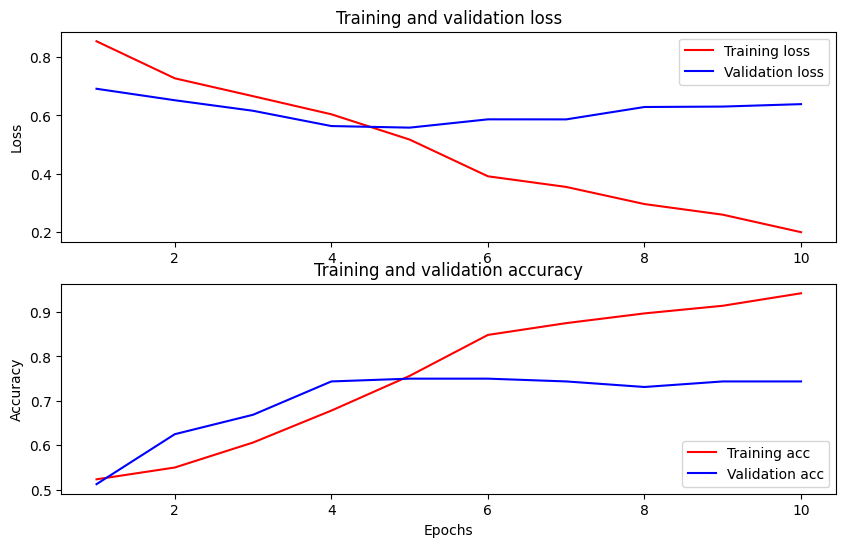

In [255]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [257]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [258]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.592679]], shape=(1, 1), dtype=float32)


In [259]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [260]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [261]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [262]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [263]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 181s 8s/step - loss: 0.8366 - binary_accuracy: 0.4984 - val_loss: 0.6813 - val_binary_accuracy: 0.6062
Epoch 2/10
20/20 [==============================] - 155s 8s/step - loss: 0.7627 - binary_accuracy: 0.5344 - val_loss: 0.6662 - val_binary_accuracy: 0.5938
Epoch 3/10
20/20 [==============================] - 157s 8s/step - loss: 0.7055 - binary_accuracy: 0.5516 - val_loss: 0.6038 - val_binary_accuracy: 0.7188
Epoch 4/10
20/20 [==============================] - 155s 8s/step - loss: 0.5922 - binary_accuracy: 0.7016 - val_loss: 0.5428 - val_binary_accuracy: 0.7625
Epoch 5/10
20/20 [==============================] - 155s 8s/step - loss: 0.4874 - binary_accuracy: 0.7812 - val_loss: 0.5419 - val_binary_accuracy: 0.7625
Epoch 6/10
20/20 [==============================] - 155s 8s/step - loss: 0.4169 - binary_accuracy: 0.8422 - val_loss: 0.5818 - val_binary_accu

In [264]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.5916 - binary_accuracy: 0.7750


In [265]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.5915587544441223
Accuracy: 0.7749999761581421


In [266]:
classifier_model

In [267]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [268]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

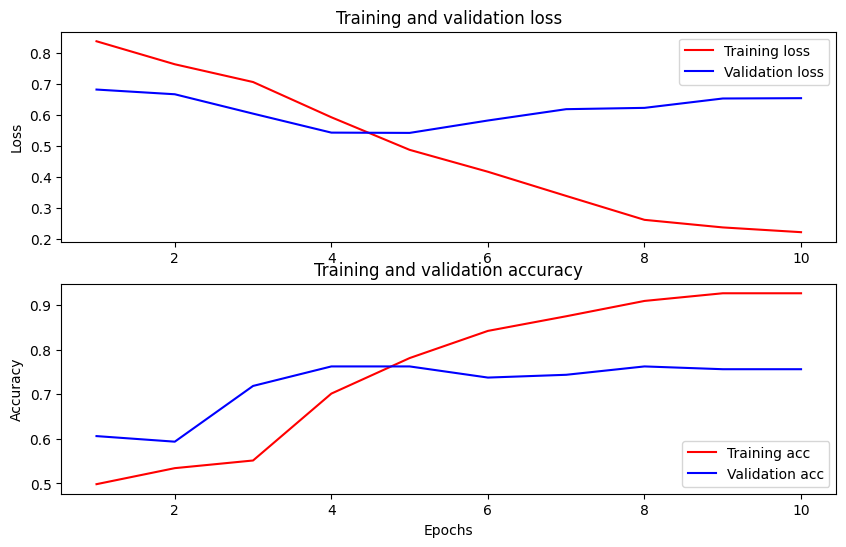

In [269]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [270]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [271]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.67143637]], shape=(1, 1), dtype=float32)


In [272]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [273]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [274]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [277]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [278]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 169s 8s/step - loss: 0.6454 - binary_accuracy: 0.6388 - val_loss: 0.5606 - val_binary_accuracy: 0.7250
Epoch 2/10
20/20 [==============================] - 155s 8s/step - loss: 0.5291 - binary_accuracy: 0.7469 - val_loss: 0.5304 - val_binary_accuracy: 0.7750
Epoch 3/10
20/20 [==============================] - 156s 8s/step - loss: 0.4334 - binary_accuracy: 0.8219 - val_loss: 0.5241 - val_binary_accuracy: 0.7750
Epoch 4/10
20/20 [==============================] - 155s 8s/step - loss: 0.3641 - binary_accuracy: 0.8641 - val_loss: 0.5854 - val_binary_accuracy: 0.7437
Epoch 5/10
20/20 [==============================] - 154s 8s/step - loss: 0.3274 - binary_accuracy: 0.8891 - val_loss: 0.6079 - val_binary_accuracy: 0.7375
Epoch 6/10
20/20 [==============================] - 156s 8s/step - loss: 0.2651 - binary_accuracy: 0.9078 - val_loss: 0.5932 - val_binary_accu

In [279]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.5981 - binary_accuracy: 0.7500


In [280]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.598128616809845
Accuracy: 0.75


In [281]:
classifier_model

In [282]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [283]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

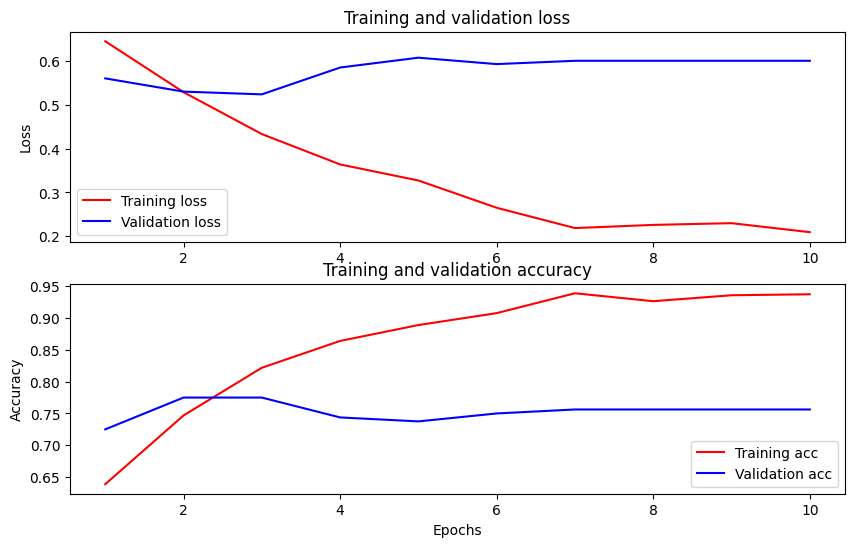

In [284]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [285]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [286]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.64921826]], shape=(1, 1), dtype=float32)


In [287]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [288]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [289]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [290]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [291]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 179s 8s/step - loss: 0.8785 - binary_accuracy: 0.4969 - val_loss: 0.7042 - val_binary_accuracy: 0.4938
Epoch 2/10
20/20 [==============================] - 158s 8s/step - loss: 0.8224 - binary_accuracy: 0.5141 - val_loss: 0.6548 - val_binary_accuracy: 0.5938
Epoch 3/10
20/20 [==============================] - 157s 8s/step - loss: 0.6913 - binary_accuracy: 0.5828 - val_loss: 0.6014 - val_binary_accuracy: 0.6875
Epoch 4/10
20/20 [==============================] - 167s 8s/step - loss: 0.5636 - binary_accuracy: 0.7281 - val_loss: 0.5090 - val_binary_accuracy: 0.7688
Epoch 5/10
20/20 [==============================] - 157s 8s/step - loss: 0.4174 - binary_accuracy: 0.8188 - val_loss: 0.5185 - val_binary_accuracy: 0.7688
Epoch 6/10
20/20 [==============================] - 156s 8s/step - loss: 0.3244 - binary_accuracy: 0.8859 - val_loss: 0.5997 - val_binary_accu

In [292]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.7063 - binary_accuracy: 0.7850


In [293]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.706347644329071
Accuracy: 0.7850000262260437


In [294]:
classifier_model

In [295]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [296]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

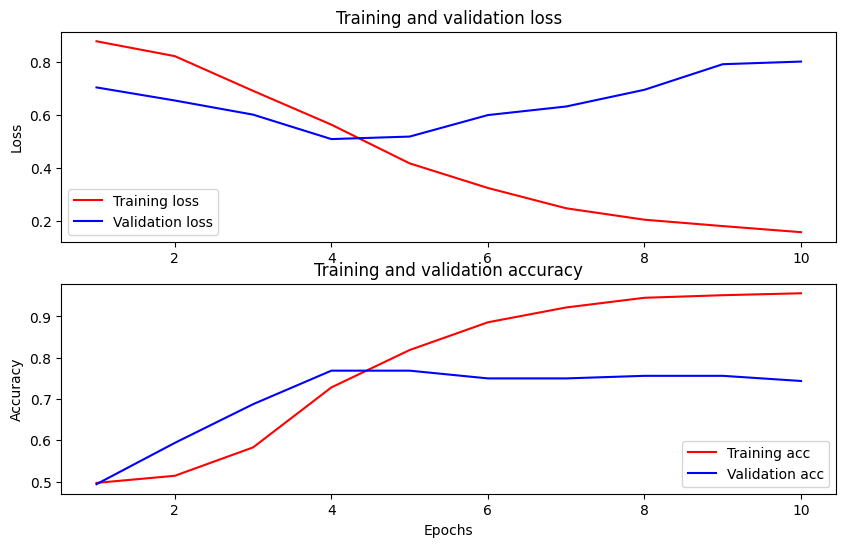

In [297]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [298]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [299]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6213484]], shape=(1, 1), dtype=float32)


In [300]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [301]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [302]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [303]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [304]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 183s 8s/step - loss: 0.8775 - binary_accuracy: 0.5063 - val_loss: 0.7168 - val_binary_accuracy: 0.5500
Epoch 2/10
20/20 [==============================] - 157s 8s/step - loss: 0.8202 - binary_accuracy: 0.4969 - val_loss: 0.6790 - val_binary_accuracy: 0.5562
Epoch 3/10
20/20 [==============================] - 156s 8s/step - loss: 0.7443 - binary_accuracy: 0.5250 - val_loss: 0.6668 - val_binary_accuracy: 0.6187
Epoch 4/10
20/20 [==============================] - 157s 8s/step - loss: 0.7095 - binary_accuracy: 0.5562 - val_loss: 0.6346 - val_binary_accuracy: 0.6313
Epoch 5/10
20/20 [==============================] - 155s 8s/step - loss: 0.6506 - binary_accuracy: 0.6141 - val_loss: 0.5985 - val_binary_accuracy: 0.6625
Epoch 6/10
20/20 [==============================] - 155s 8s/step - loss: 0.5563 - binary_accuracy: 0.6922 - val_loss: 0.5498 - val_binary_accu

In [305]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.5714 - binary_accuracy: 0.7500


In [306]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.5714097023010254
Accuracy: 0.75


In [307]:
classifier_model

In [308]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [309]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

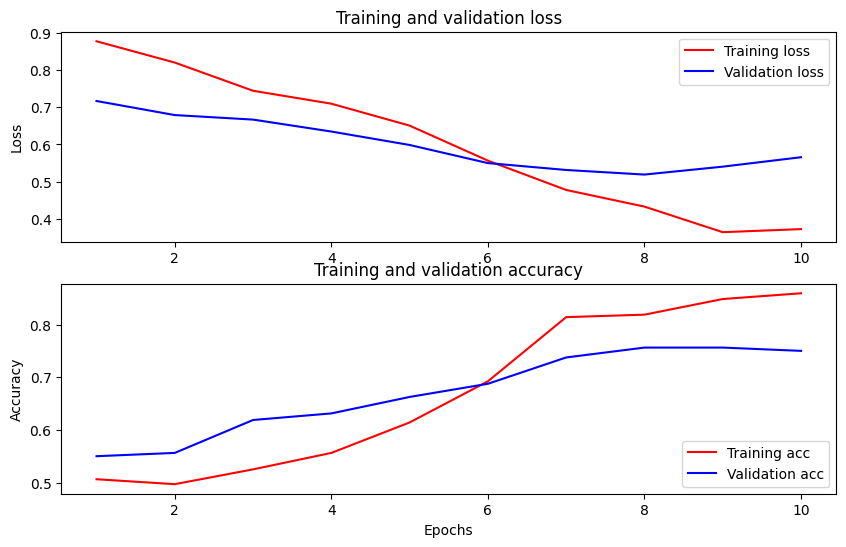

In [310]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [311]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [312]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6601166]], shape=(1, 1), dtype=float32)


In [313]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [314]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [315]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [316]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [317]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 178s 8s/step - loss: 0.8070 - binary_accuracy: 0.5516 - val_loss: 0.6864 - val_binary_accuracy: 0.5063
Epoch 2/10
20/20 [==============================] - 156s 8s/step - loss: 0.7608 - binary_accuracy: 0.5234 - val_loss: 0.6859 - val_binary_accuracy: 0.5625
Epoch 3/10
20/20 [==============================] - 157s 8s/step - loss: 0.7404 - binary_accuracy: 0.5375 - val_loss: 0.6646 - val_binary_accuracy: 0.5875
Epoch 4/10
20/20 [==============================] - 157s 8s/step - loss: 0.6979 - binary_accuracy: 0.5594 - val_loss: 0.6510 - val_binary_accuracy: 0.6125
Epoch 5/10
20/20 [==============================] - 157s 8s/step - loss: 0.6602 - binary_accuracy: 0.6219 - val_loss: 0.5911 - val_binary_accuracy: 0.6812
Epoch 6/10
20/20 [==============================] - 157s 8s/step - loss: 0.5711 - binary_accuracy: 0.7109 - val_loss: 0.5413 - val_binary_accu

In [318]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 15s 2s/step - loss: 0.5562 - binary_accuracy: 0.7350


In [319]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.5562030673027039
Accuracy: 0.7350000143051147


In [320]:
classifier_model

In [321]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [322]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

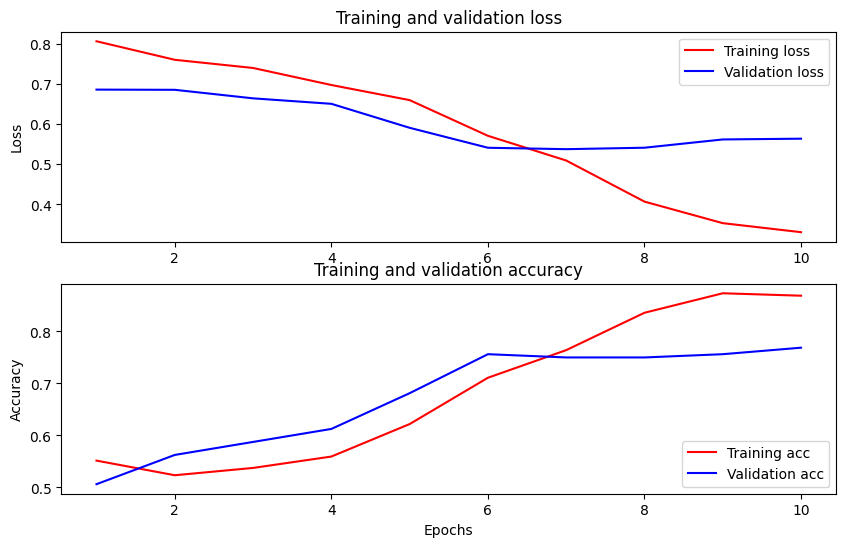

In [323]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [38]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [39]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.46171725]], shape=(1, 1), dtype=float32)


In [40]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [41]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [42]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [43]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [44]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
200/200 [==============================] - 204s 951ms/step - loss: 0.5638 - binary_accuracy: 0.6675 - val_loss: 0.4364 - val_binary_accuracy: 0.8087
Epoch 2/10
200/200 [==============================] - 189s 948ms/step - loss: 0.4039 - binary_accuracy: 0.8195 - val_loss: 0.4269 - val_binary_accuracy: 0.7956
Epoch 3/10
200/200 [==============================] - 189s 948ms/step - loss: 0.2934 - binary_accuracy: 0.8838 - val_loss: 0.4806 - val_binary_accuracy: 0.8125
Epoch 4/10
200/200 [==============================] - 189s 947ms/step - loss: 0.2170 - binary_accuracy: 0.9203 - val_loss: 0.6191 - val_binary_accuracy: 0.7919
Epoch 5/10
200/200 [==============================] - 189s 947ms/step - loss: 0.1721 - binary_accuracy: 0.9413 - val_loss: 0.8725 - val_binary_accuracy: 0.7594
Epoch 6/10
200/200 [==============================] - 189s 948ms/step - loss: 0.1104 - binary_accuracy: 0.9639 - val_

In [45]:
loss, accuracy = classifier_model4.evaluate(test_ds)

63/63 [==============================] - 19s 306ms/step - loss: 1.1561 - binary_accuracy: 0.7780


In [46]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 1.1560583114624023
Accuracy: 0.777999997138977


In [47]:
classifier_model

In [48]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [49]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

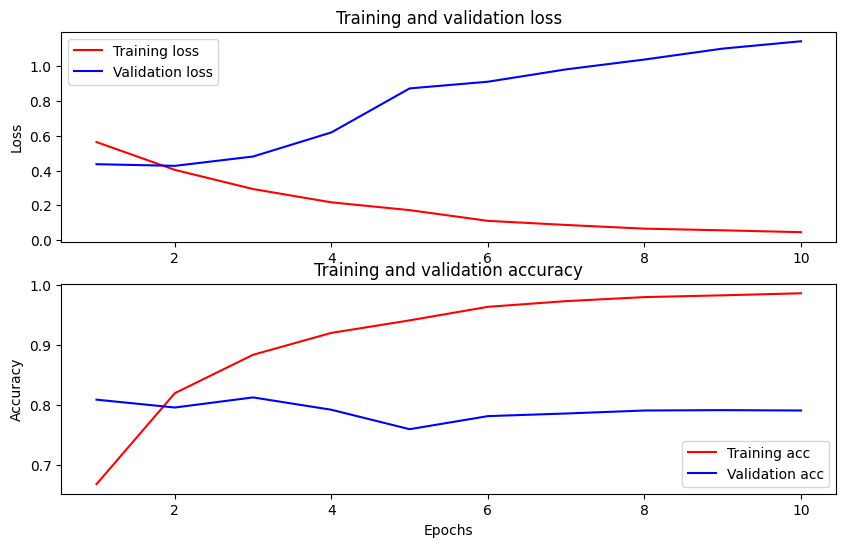

In [50]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [51]:
reviews_df = df2.drop(columns=['product_title', 'helpful_votes', 'total_votes', 'review_headline', 'verified_purchase', 'year', 'month'])

In [71]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(5000, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(5000, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [72]:
# assigning Reviewer_Score as target variable and everything else as X
X = reviews_df.drop(columns=['star_rating'])
y = reviews_df['star_rating']

In [73]:
# splitting the data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1, stratify=y_remainder)

In [75]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [76]:
text_test = [reviews_df['review_body'].iloc[0]]
text_test

['narrow for my wide foot ']

In [77]:
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4867 2005 2026 2898 3329  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [78]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [79]:
bert_results = bert_model(text_preprocessed)

In [80]:
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.7115109  -0.1471918   0.6560653   0.5590661  -0.24392979 -0.00215006
  0.7893182   0.00846878  0.45635504 -0.99916565  0.2196476   0.02172825]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.33388656  0.07720743 -0.01138503 ... -0.11056352 -0.03026427
   0.0604934 ]
 [-0.36681232 -0.42698842  0.30252558 ... -0.08066519 -0.07146209
  -0.20315284]
 [ 0.80757695 -0.20368266  0.5635261  ... -0.2627955   0.11249168
   0.2211068 ]
 ...
 [-0.33817643 -0.05785348  0.26757756 ...  0.3020348  -0.09277816
   0.05979608]
 [-0.59446985 -0.42638984  0.04232744 ...  0.5373386  -0.10326371
  -0.02443141]
 [-0.6302548  -0.36392957  0.10703664 ...  0.42417052 -0.2517214
   0.21893288]]


In [114]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [115]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6420588]], shape=(1, 1), dtype=float32)


In [116]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [117]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [118]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(32)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [119]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [120]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [121]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [122]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
200/200 [==============================] - 203s 945ms/step - loss: 0.6659 - binary_accuracy: 0.6122 - val_loss: 0.4624 - val_binary_accuracy: 0.8138
Epoch 2/10
200/200 [==============================] - 190s 950ms/step - loss: 0.4503 - binary_accuracy: 0.7880 - val_loss: 0.4435 - val_binary_accuracy: 0.8081
Epoch 3/10
200/200 [==============================] - 190s 951ms/step - loss: 0.3439 - binary_accuracy: 0.8589 - val_loss: 0.5924 - val_binary_accuracy: 0.8106
Epoch 4/10
200/200 [==============================] - 190s 950ms/step - loss: 0.2740 - binary_accuracy: 0.8933 - val_loss: 0.6182 - val_binary_accuracy: 0.7950
Epoch 5/10
200/200 [==============================] - 190s 949ms/step - loss: 0.2120 - binary_accuracy: 0.9262 - val_loss: 0.7818 - val_binary_accuracy: 0.8156
Epoch 6/10
200/200 [==============================] - 190s 949ms/step - loss: 0.1702 - binary_accuracy: 0.9466 - val_

In [123]:
loss, accuracy = classifier_model.evaluate(test_ds)

63/63 [==============================] - 19s 304ms/step - loss: 1.0974 - binary_accuracy: 0.8105


In [124]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 1.0973942279815674
Accuracy: 0.8105000257492065


In [125]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [126]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [137]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)epochs = range(1, len(acc) + 1)

SyntaxError: invalid syntax (400719569.py, line 17)

In [138]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.22572298]], shape=(1, 1), dtype=float32)


In [139]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [140]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [141]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [135]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [136]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[4096,3072] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transformer/layer_11/intermediate/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1079674]

In [ ]:
loss, accuracy = classifier_model4.evaluate(test_ds)

In [ ]:
history_dict = history.history
print(history_dict.keys())

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [ ]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [184]:
def build_classifier_model4():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [185]:
classifier_model4 = build_classifier_model()
bert_raw_result = classifier_model4(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5661616]], shape=(1, 1), dtype=float32)


In [186]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [187]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(16)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(16)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(16)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [188]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [189]:
init_lr = 0.00001
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [190]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [191]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
400/400 [==============================] - 211s 490ms/step - loss: 0.6831 - binary_accuracy: 0.6027 - val_loss: 0.5372 - val_binary_accuracy: 0.7706
Epoch 2/10
400/400 [==============================] - 197s 492ms/step - loss: 0.4906 - binary_accuracy: 0.7755 - val_loss: 0.4433 - val_binary_accuracy: 0.8238
Epoch 3/10
400/400 [==============================] - 197s 492ms/step - loss: 0.4047 - binary_accuracy: 0.8317 - val_loss: 0.4960 - val_binary_accuracy: 0.8119
Epoch 4/10
400/400 [==============================] - 197s 492ms/step - loss: 0.3409 - binary_accuracy: 0.8667 - val_loss: 0.6246 - val_binary_accuracy: 0.8156
Epoch 5/10
400/400 [==============================] - 197s 492ms/step - loss: 0.2801 - binary_accuracy: 0.9027 - val_loss: 0.8115 - val_binary_accuracy: 0.7837
Epoch 6/10
400/400 [==============================] - 197s 492ms/step - loss: 0.2595 - binary_accuracy: 0.9178 - val_

In [192]:
loss, accuracy = classifier_model4.evaluate(test_ds)

125/125 [==============================] - 19s 150ms/step - loss: 1.0066 - binary_accuracy: 0.8005


In [193]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 1.0066416263580322
Accuracy: 0.8004999756813049


In [194]:
classifier_model

In [195]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [196]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

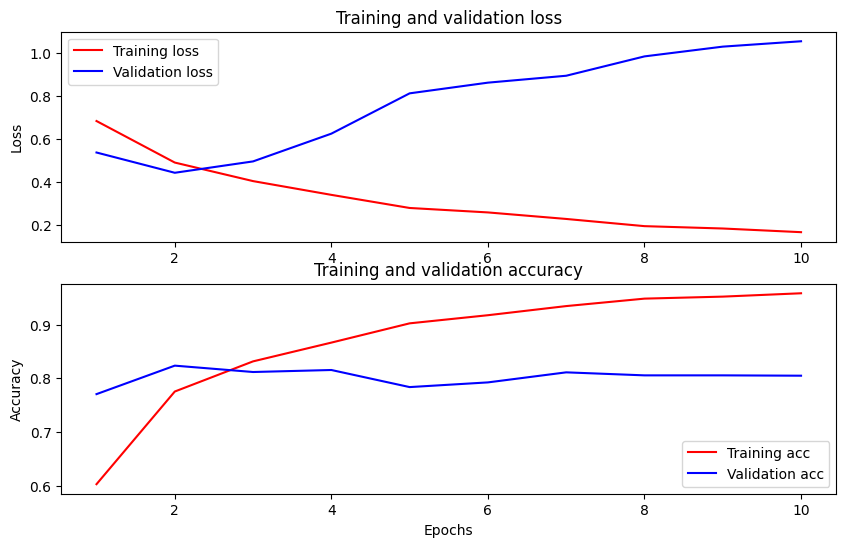

In [197]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [458]:
reviews_df = df.drop(columns=['product_title', 'helpful_votes', 'total_votes', 'review_headline', 'verified_purchase', 'year', 'month'])

In [459]:
rating1 = reviews_df[reviews_df['star_rating']==1].sample(1000, random_state=1)
rating2 = reviews_df[reviews_df['star_rating']==2].sample(1000, random_state=1)
rating3 = reviews_df[reviews_df['star_rating']==3].sample(1000, random_state=1)
rating4 = reviews_df[reviews_df['star_rating']==4].sample(1000, random_state=1)
rating5 = reviews_df[reviews_df['star_rating']==5].sample(1000, random_state=1)

reviews_df = pd.concat([rating1, rating2, rating3, rating4, rating5])
reviews_df['star_rating'] = reviews_df['star_rating'].apply(lambda x: x - 1)

In [460]:
# assigning Reviewer_Score as target variable and everything else as X
X = reviews_df.drop(columns=['star_rating'])
y = reviews_df['star_rating']

In [461]:
# splitting the data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1, stratify=y_remainder)

In [462]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(16)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(16)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(16)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [463]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [468]:
classifier_model4 = build_classifier_model()

loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 2e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adam',
#                                           beta_1=0.9, 
#                                           beta_2=0.999, 
#                                           epsilon=1e-08)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=init_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [469]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
200/200 [==============================] - 139s 499ms/step - loss: 1.7031 - categorical_accuracy: 0.2459 - val_loss: 1.3996 - val_categorical_accuracy: 0.3900
Epoch 2/5
200/200 [==============================] - 93s 468ms/step - loss: 1.4290 - categorical_accuracy: 0.3537 - val_loss: 1.2559 - val_categorical_accuracy: 0.3950
Epoch 3/5
200/200 [==============================] - 93s 467ms/step - loss: 1.2427 - categorical_accuracy: 0.4466 - val_loss: 1.1029 - val_categorical_accuracy: 0.5312
Epoch 4/5
200/200 [==============================] - 93s 466ms/step - loss: 1.0933 - categorical_accuracy: 0.5203 - val_loss: 1.1103 - val_categorical_accuracy: 0.5238
Epoch 5/5
200/200 [==============================] - 93s 466ms/step - loss: 0.9361 - categorical_accuracy: 0.6044 - val_loss: 1.3144 - val_categorical_accuracy: 0.4988


In [470]:
loss, accuracy = classifier_model4.evaluate(test_ds)

63/63 [==============================] - 9s 149ms/step - loss: 1.4567 - categorical_accuracy: 0.4480


In [471]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 1.456655502319336
Accuracy: 0.4480000138282776


In [472]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [473]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

KeyError: 'binary_accuracy'

In [ ]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [328]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [329]:
classifier_model20 = build_classifier_model()
bert_raw_result = classifier_model20(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6097501]], shape=(1, 1), dtype=float32)


In [330]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [331]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(16)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(16)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(16)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [332]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [333]:
init_lr = 2e-05
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [336]:
classifier_model20.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [337]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model20.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


400/400 [==============================] - 210s 491ms/step - loss: 0.5897 - binary_accuracy: 0.6923 - val_loss: 0.4318 - val_binary_accuracy: 0.8081
Epoch 2/2
400/400 [==============================] - 197s 493ms/step - loss: 0.4058 - binary_accuracy: 0.8295 - val_loss: 0.4530 - val_binary_accuracy: 0.8169


In [338]:
loss, accuracy = classifier_model20.evaluate(test_ds)

125/125 [==============================] - 19s 148ms/step - loss: 0.4805 - binary_accuracy: 0.7955


In [342]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.4804651439189911
Accuracy: 0.7954999804496765


In [343]:
classifier_model

In [344]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [345]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

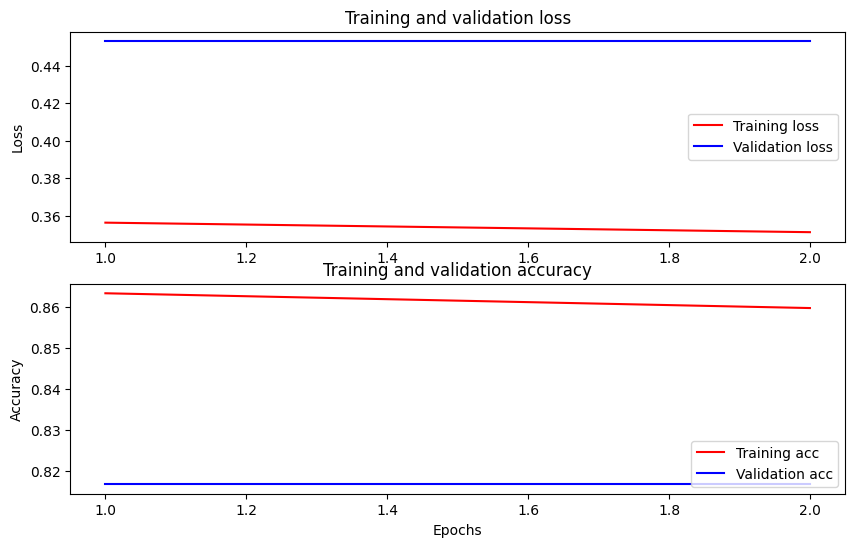

In [346]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [347]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    # net = tf.keras.layers.Dense(512, activation='relu')(net)
    # net = tf.keras.layers.Dense(256, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(64, activation='relu')(net)
    # net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [349]:
classifier_model21 = build_classifier_model()
bert_raw_result = classifier_model20(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.50497484]], shape=(1, 1), dtype=float32)


In [350]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

In [351]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(16)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(16)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(16)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [353]:
epochs = 4
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [354]:
init_lr = 2e-05
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [355]:
classifier_model21.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [356]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model21.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/4
400/400 [==============================] - 212s 494ms/step - loss: 0.6498 - binary_accuracy: 0.6469 - val_loss: 0.4437 - val_binary_accuracy: 0.8087
Epoch 2/4
400/400 [==============================] - 197s 493ms/step - loss: 0.4325 - binary_accuracy: 0.8247 - val_loss: 0.4499 - val_binary_accuracy: 0.8056
Epoch 3/4
400/400 [==============================] - 197s 493ms/step - loss: 0.3298 - binary_accuracy: 0.8806 - val_loss: 0.5239 - val_binary_accuracy: 0.8138
Epoch 4/4
400/400 [==============================] - 197s 493ms/step - loss: 0.2674 - binary_accuracy: 0.9083 - val_loss: 0.6101 - val_binary_accuracy: 0.8100


In [357]:
loss, accuracy = classifier_model21.evaluate(test_ds)

125/125 [==============================] - 19s 150ms/step - loss: 0.6562 - binary_accuracy: 0.7960


In [358]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.6562223434448242
Accuracy: 0.7960000038146973


In [360]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [361]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

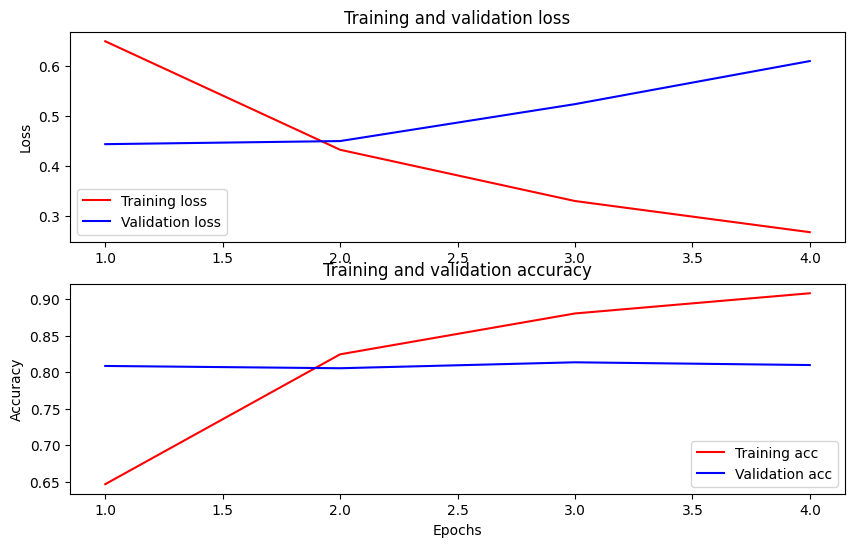

In [362]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [376]:
tf.sigmoid(classifier_model21(tf.constant(['This shoes are pretty good'])))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.55383044]], dtype=float32)>

In [474]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")

model = TFAutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [476]:
model.compile()
model.evaluate(test_ds)

TypeError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1765, in test_step
        y_pred = self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/tmp/__autograph_generated_file1zym22of.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/tmp/__autograph_generated_filew59qfiry.py", line 17, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).bert, (), dict(input_ids=ag__.ld(input_ids), attention_mask=ag__.ld(attention_mask), token_type_ids=ag__.ld(token_type_ids), position_ids=ag__.ld(position_ids), head_mask=ag__.ld(head_mask), inputs_embeds=ag__.ld(inputs_embeds), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/var/tmp/__autograph_generated_file1zym22of.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "/var/tmp/__autograph_generated_fileln7b7r15.py", line 127, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(input_ids=ag__.ld(input_ids), position_ids=ag__.ld(position_ids), token_type_ids=ag__.ld(token_type_ids), inputs_embeds=ag__.ld(inputs_embeds), past_key_values_length=ag__.ld(past_key_values_length), training=ag__.ld(training)), fscope)
    File "/var/tmp/__autograph_generated_filej4oxo30g.py", line 46, in tf__call
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
    File "/var/tmp/__autograph_generated_filej4oxo30g.py", line 40, in if_body_1
        ag__.converted_call(ag__.ld(check_embeddings_within_bounds), (ag__.ld(input_ids), ag__.ld(self).config.vocab_size), None, fscope)
    File "/var/tmp/__autograph_generated_file8owsaycx.py", line 17, in tf__check_embeddings_within_bounds
        ag__.converted_call(ag__.ld(tf).debugging.assert_less, (ag__.ld(tensor), ag__.converted_call(ag__.ld(tf).cast, (ag__.ld(embed_dim),), dict(dtype=ag__.ld(tensor).dtype), fscope)), dict(message=f"The maximum value of {ag__.ld(tensor_name)} ({ag__.converted_call(ag__.ld(tf).math.reduce_max, (ag__.ld(tensor),), None, fscope)}) must be smaller than the embedding layer's input dimension ({ag__.ld(embed_dim)}). The likely cause is some problem at tokenization time."), fscope)

    TypeError: Exception encountered when calling layer 'tf_bert_for_sequence_classification_3' (type TFBertForSequenceClassification).
    
    in user code:
    
        File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 712, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1569, in call  *
            outputs = self.bert(
        File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/tmp/__autograph_generated_file1zym22of.py", line 37, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "/var/tmp/__autograph_generated_fileln7b7r15.py", line 127, in tf__call
            embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(input_ids=ag__.ld(input_ids), position_ids=ag__.ld(position_ids), token_type_ids=ag__.ld(token_type_ids), inputs_embeds=ag__.ld(inputs_embeds), past_key_values_length=ag__.ld(past_key_values_length), training=ag__.ld(training)), fscope)
        File "/var/tmp/__autograph_generated_filej4oxo30g.py", line 46, in tf__call
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
        File "/var/tmp/__autograph_generated_filej4oxo30g.py", line 40, in if_body_1
            ag__.converted_call(ag__.ld(check_embeddings_within_bounds), (ag__.ld(input_ids), ag__.ld(self).config.vocab_size), None, fscope)
        File "/var/tmp/__autograph_generated_file8owsaycx.py", line 17, in tf__check_embeddings_within_bounds
            ag__.converted_call(ag__.ld(tf).debugging.assert_less, (ag__.ld(tensor), ag__.converted_call(ag__.ld(tf).cast, (ag__.ld(embed_dim),), dict(dtype=ag__.ld(tensor).dtype), fscope)), dict(message=f"The maximum value of {ag__.ld(tensor_name)} ({ag__.converted_call(ag__.ld(tf).math.reduce_max, (ag__.ld(tensor),), None, fscope)}) must be smaller than the embedding layer's input dimension ({ag__.ld(embed_dim)}). The likely cause is some problem at tokenization time."), fscope)
    
        TypeError: Exception encountered when calling layer 'bert' (type TFBertMainLayer).
        
        in user code:
        
            File "/opt/conda/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 712, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 780, in call  *
                embedding_output = self.embeddings(
            File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/var/tmp/__autograph_generated_filej4oxo30g.py", line 46, in tf__call
                ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('inputs_embeds',), 1)
            File "/var/tmp/__autograph_generated_filej4oxo30g.py", line 40, in if_body_1
                ag__.converted_call(ag__.ld(check_embeddings_within_bounds), (ag__.ld(input_ids), ag__.ld(self).config.vocab_size), None, fscope)
            File "/var/tmp/__autograph_generated_file8owsaycx.py", line 17, in tf__check_embeddings_within_bounds
                ag__.converted_call(ag__.ld(tf).debugging.assert_less, (ag__.ld(tensor), ag__.converted_call(ag__.ld(tf).cast, (ag__.ld(embed_dim),), dict(dtype=ag__.ld(tensor).dtype), fscope)), dict(message=f"The maximum value of {ag__.ld(tensor_name)} ({ag__.converted_call(ag__.ld(tf).math.reduce_max, (ag__.ld(tensor),), None, fscope)}) must be smaller than the embedding layer's input dimension ({ag__.ld(embed_dim)}). The likely cause is some problem at tokenization time."), fscope)
        
            TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).
            
            in user code:
            
                File "/opt/conda/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 202, in call  *
                    check_embeddings_within_bounds(input_ids, self.config.vocab_size)
                File "/opt/conda/lib/python3.10/site-packages/transformers/tf_utils.py", line 161, in check_embeddings_within_bounds  *
                    tf.debugging.assert_less(
            
                TypeError: Value passed to parameter 'input' has DataType string not in list of allowed values: float32, float64, int32, uint8, int16, int8, int64, bfloat16, uint16, float16, uint32, uint64, qint8, quint8, qint32, qint16, quint16
            
            
            Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
              • input_ids=tf.Tensor(shape=(None, 1), dtype=string)
              • position_ids=None
              • token_type_ids=tf.Tensor(shape=(None, 1), dtype=int32)
              • inputs_embeds=None
              • past_key_values_length=0
              • training=False
        
        
        Call arguments received by layer 'bert' (type TFBertMainLayer):
          • input_ids=tf.Tensor(shape=(None, 1), dtype=string)
          • attention_mask=None
          • token_type_ids=None
          • position_ids=None
          • head_mask=None
          • inputs_embeds=None
          • encoder_hidden_states=None
          • encoder_attention_mask=None
          • past_key_values=None
          • use_cache=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tf_bert_for_sequence_classification_3' (type TFBertForSequenceClassification):
      • input_ids={'input_ids': 'tf.Tensor(shape=(None, 1), dtype=string)', 'labels': 'tf.Tensor(shape=(None, 5), dtype=float32)'}
      • attention_mask=None
      • token_type_ids=None
      • position_ids=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=False
